# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
#імпорт необхідних бібліотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Анна\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#зчитуємо дані, знайомимось зі структурою
df = pd.read_csv("tweet_sentiment_train.csv.zip")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [4]:
#аналізуємо пропущені значення
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
0,textID,0,0.0
1,text,1,0.0
2,selected_text,1,0.0
3,sentiment,0,0.0


In [5]:
#видаляємо пропущенні значення
df = df.dropna()
df.info(verbose = True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



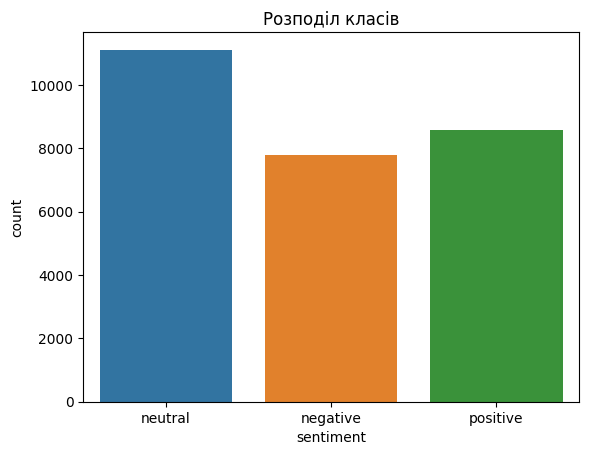

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


In [6]:
# Підрахунок кількості елементів в кожному класі
class_counts = df['sentiment'].value_counts()

# Візуалізація розподілу класів
sns.countplot(x='sentiment', data=df)
plt.title('Розподіл класів')
plt.show()

print(class_counts)

c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


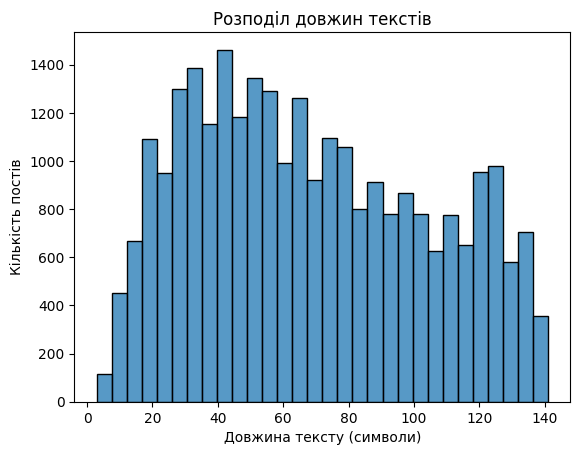

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


In [7]:
# Розрахунок довжини кожного тексту
df['text_length'] = df['text'].apply(len)

# Візуалізація розподілу довжин
sns.histplot(data=df, x="text_length", bins=30)
plt.title('Розподіл довжин текстів')
plt.xlabel('Довжина тексту (символи)')
plt.ylabel('Кількість постів')
plt.show()

# Описальна статистика
print(df['text_length'].describe())

**Спостереження:**
- найменша довжина тексту складає 3 символи, найбільша - 141
- середнє значення 68 символів, медіана (50-ї персентиль) - 64 (кіл-ть символів, що частіше зустрічається). Це свідчить про зміщення розподілу, наявність хвоста
- відсутні викиди в даних

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [8]:
#функція для попередньої обробки
def preprocess_text(text):
    # Токенізація
    tokens = text.split()
    
    # Видалення стоп-слів (замість 'english' можна використати іншу мову)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Стеммінг
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Приєднання токенів назад в рядок
    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text

In [9]:
# векторизація
df['preprocessed_text'] = df['text'].apply(preprocess_text)

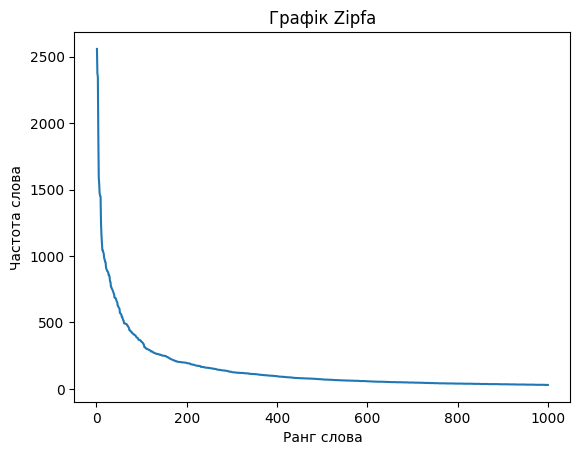

In [10]:
# задаємо кіл-ть слів у словнику, наприклад 1000
vectorizer = CountVectorizer(max_features=1000)

# Фиттинг і трансформація
X = vectorizer.fit_transform(df['preprocessed_text'])

# попрацюємо над частотою використання слів
# Отримаємо список всіх слів у словнику та їх відповідні індекси
words = vectorizer.get_feature_names_out()

# Перетворимо матрицю терм-документів в масив і підрахуємо суму по рядках
word_counts = X.sum(axis=0)
word_counts = np.squeeze(np.asarray(word_counts))

# Створимо словник, де ключем є слово, а значенням - його частота
word_freq = dict(zip(words, word_counts))

# Сортуємо слова за спаданням частоти
sorted_word_freq = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)

# Отримаємо ранги слів
ranks = np.arange(1, len(sorted_word_freq) + 1)

# Візуалізуємо графік Zipfa
plt.plot(ranks, [freq for (word, freq) in sorted_word_freq])
plt.xlabel('Ранг слова')
plt.ylabel('Частота слова')
plt.title('Графік Zipfa')
plt.show()

**Спостереження:**
бачимо, що після 200 слів, їх частота починає зменшуватися. Це може свідчити про те, що додавання більшої кіл-ті слів не пренесе нам значного покращення результату.

Для подальшої роботи в CountVectorizer.будемо використовувати max_features=200

In [11]:
# задаємо кіл-ть слів у словнику, наприклад 1000
vectorizer = CountVectorizer(max_features=200)

# Фиттинг і трансформація
X = vectorizer.fit_transform(df['preprocessed_text'])

# Перетворення в DataFrame для кращої читабельності
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [12]:
# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

# Векторизація
#vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Навчання моделей
# Логістична регресія
logreg = LogisticRegression()
logreg.fit(X_train_bow, y_train)

# Дерево рішень
dt = DecisionTreeClassifier()
dt.fit(X_train_bow, y_train)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_bow, y_train)

# Передбачення на тестовому наборі
y_pred_logreg = logreg.predict(X_test_bow)
y_pred_dt = dt.predict(X_test_bow)
y_pred_rf = rf.predict(X_test_bow)

# Оцінка якості
print("Логістична регресія:")
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))

print("Дерево рішень:")
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Логістична регресія:
              precision    recall  f1-score   support

    negative       0.60      0.41      0.48      1572
     neutral       0.54      0.75      0.63      2236
    positive       0.76      0.60      0.67      1688

    accuracy                           0.60      5496
   macro avg       0.63      0.59      0.59      5496
weighted avg       0.62      0.60      0.60      5496

[[ 638  847   87]
 [ 325 1671  240]
 [ 105  567 1016]]
Дерево рішень:
              precision    recall  f1-score   support

    negative       0.48      0.48      0.48      1572
     neutral       0.53      0.55      0.54      2236
    positive       0.59      0.56      0.58      1688

    accuracy                           0.54      5496
   macro avg       0.54      0.53      0.53      5496
weighted avg       0.54      0.54      0.54      5496

[[ 760  593  219]
 [ 563 1240  433]
 [ 249  490  949]]
Random Forest:
              precision    recall  f1-score   support

    negative       0.5

**Спостереження:**
- Аналізуючи f1-score чпостерігаємо ни зький показник всіх трьох моделей при класифікації "negative"
- При цьому Логістична регресія і Random Forest показали кращі результати при класифікації neutral і positive

Для подальшої роботи будемо використовувати модель Логістичної регресії

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [13]:
# Отримання коефіцієнтів моделі
coefs = pd.DataFrame({'word': vectorizer.get_feature_names_out(), 'coef': logreg.coef_[0]})
coefs = coefs.sort_values(by='coef', ascending=False)

# Виведення 10 найважливіших слів
print(coefs.head(10))
print(coefs.tail(10))

      word      coef
130    sad  2.144010
62    hate  1.941754
142  sorry  1.900290
96    miss  1.599857
137   sick  1.564332
160  tired  1.389967
15     bad  1.118294
27    cant  0.797700
44    feel  0.739121
112    not  0.645307
        word      coef
72      hope -1.027421
21      best -1.095330
60     happy -1.124251
57     great -1.219604
109     nice -1.238708
30      cool -1.253607
148   thanks -1.419116
147    thank -1.501879
92      love -1.634461
13   awesome -2.063832


**Спостереження:**
Досить логічними є найвпливовіші слова

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [14]:
# Векторизація TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Навчання моделі на TF-IDF векторах
logreg_tfidf = LogisticRegression()
logreg_tfidf.fit(X_train_tfidf, y_train)

# Оцінка якості
y_pred_tfidf = logreg_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf))

# Отримання коефіцієнтів моделі
tfidf_coefs = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names_out(), 'tfidf_coef': logreg_tfidf.coef_[0]})
tfidf_coefs = tfidf_coefs.sort_values(by='tfidf_coef', ascending=False)
print(tfidf_coefs.head(10))
print(tfidf_coefs.tail(10))

              precision    recall  f1-score   support

    negative       0.70      0.59      0.64      1572
     neutral       0.63      0.73      0.68      2236
    positive       0.78      0.72      0.75      1688

    accuracy                           0.69      5496
   macro avg       0.70      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496

          word  tfidf_coef
17540      sad    5.706429
13553     miss    5.623335
18845    sorry    5.124681
9981      hate    4.682691
19498    sucks    4.625395
18302     sick    3.751193
15910     poor    3.731963
3983     bored    3.688276
13561  missing    3.553835
19441   stupid    3.523808
            word  tfidf_coef
10444  hopefully   -2.579547
3574      better   -2.590490
9390        good   -2.645571
9284        glad   -2.730220
14292       nice   -2.855475
9564       great   -2.970651
20149     thanks   -3.317256
10439       hope   -3.323304
3024     awesome   -3.442543
12682       love   -4.694006


c:\users\анна\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Спостереження:**
- Бачимо, що при використанні TF-IDF у нас покращилися результати моделі, виріс f1-score зокрема у класу negative
- Також дещо змінився порядок приорітетних слів

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [15]:
# Аналіз помилкових класифікацій
print(confusion_matrix(y_test, y_pred_tfidf))

[[ 930  560   82]
 [ 334 1640  262]
 [  58  414 1216]]


**Спостереження:**
- Найкраще класифікується: Клас "positive" має найбільше правильних класифікацій на діагоналі.
- Найгірше класифікується: Клас "negative" має найбільше помилкових класифікацій. Модель часто плутає негативні відгуки з нейтральними.
- Загальна тенденція: Модель має проблеми з диференціацією між негативними та нейтральними відгуками.


**Пропозиції щодо поліпшення якості:**
- Застосувати методи балансування класів (oversampling, undersampling, SMOTE).
- Використовувати більш складні методи препроцесингу, наприклад,як лематизація
- Тюнінг гіперпараметрів: Підібрати оптимальні значення гіперпараметрів для моделі та векторизатора.

In [16]:
for i, (true_label, predicted_label, text) in enumerate(zip(y_test, y_pred_tfidf, X_test_tfidf)):
    if true_label != predicted_label:
        print(f"Index: {i}, True: {true_label}, Predicted: {predicted_label}, Text: {text}")

Index: 1, True: negative, Predicted: neutral, Text:   (0, 2305)	0.13443540034093837
  (0, 2478)	0.19435361766675507
  (0, 4452)	0.2261095629410564
  (0, 6523)	0.3597798391394072
  (0, 6788)	0.32142372456679846
  (0, 7848)	0.26641664537253207
  (0, 10358)	0.31604182487580923
  (0, 11204)	0.09681023759333228
  (0, 11822)	0.2276615179990035
  (0, 13205)	0.11559897817704788
  (0, 13748)	0.16530432589021082
  (0, 14663)	0.33982719840037845
  (0, 14666)	0.16563842643082777
  (0, 20193)	0.36452658096397933
  (0, 20198)	0.17453754073282096
  (0, 20945)	0.28506319541831737
Index: 17, True: negative, Predicted: neutral, Text:   (0, 2882)	0.313154128981604
  (0, 6394)	0.30676259996819216
  (0, 13543)	0.7402839957312011
  (0, 22132)	0.36539100056474944
  (0, 22470)	0.3553874239939648
Index: 21, True: negative, Predicted: positive, Text:   (0, 5575)	0.7398579971317123
  (0, 9782)	0.45409793070321325
  (0, 22351)	0.49639219717005106
Index: 25, True: positive, Predicted: neutral, Text:   (0, 2882)	0.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model